In [14]:
import autograd.numpy as np
from autograd import grad
import autograd

import scipy.optimize

In [2]:
import matplotlib.pyplot as plt 

In [33]:
evaluation_points = np.linspace(0, 1, 50)
sigma = 0.1

In [34]:
def psi(theta): 
    return np.exp(-((evaluation_points - theta)/sigma)**2)

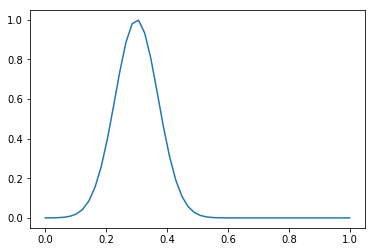

In [35]:
plt.plot(evaluation_points, psi(0.3))

In [36]:
def Psi(ws, thetas): 
    return np.sum(np.array([w*psi(theta) for (w, theta) in zip(ws, thetas)]),0)

In [37]:
def ell(ws, thetas): 
    return ((Psi(ws, thetas) - y)**2).sum()

In [41]:
num_true_thetas = 4 
noise_level = 0.1 
true_thetas = np.random.rand(num_true_thetas)
true_weights = np.random.rand(num_true_thetas) + 1

In [42]:
y = Psi(true_weights, true_thetas) + np.random.randn(len(evaluation_points)) * noise_level

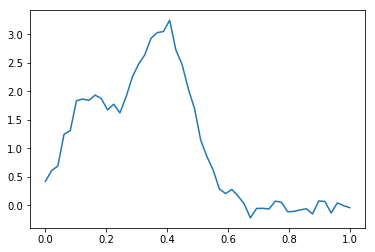

In [43]:
plt.plot(evaluation_points, y)

In [44]:
grid_points = np.linspace(0, 1, 30)
grid_psi = np.stack([psi(tt) for tt in grid_points])

In [45]:
def lmo(v): 
    scores = np.matmul(grid_psi, v)
    return grid_points[scores.argmin()]

In [62]:
def coordinate_descent(thetas, iters=35, min_drop=1e-5): 
    def min_ws(): 
        return scipy.optimize.nnls(np.stack([psi(tt) for tt in thetas]).T, y)[0]
    def min_thetas(): 
        res =  scipy.optimize.minimize(autograd.value_and_grad(lambda tts: ell(ws, tts)), thetas, jac=True, method='L-BFGS-B', bounds=[(0.0, 1.0)]*len(thetas))
        return res['x'], res['fun']
    old_f_val = np.Inf
    for iter in range(iters): 
        ws = min_ws()
        thetas, f_val = min_thetas()
        print ws, thetas
        if old_f_val - f_val < min_drop: 
            break 
        old_f_val = f_val 
    return ws, thetas

In [47]:
def local_search(thetas): 
    n = len(thetas)
    def f(x): 
        return ell(x[:n], x[n:])
    x_init = np.concatenate((np.zeros(n), thetas))
    res = scipy.optimize.minimize(autograd.value_and_grad(f), x_init, jac=True, method='L-BFGS-B',bounds=([(0.0, None)]*n)+([(0.0,1.0)]*n))
    x = res['x']
    ws = x[:n]
    thetas = x[n:]
    return ws, thetas

In [57]:
def ADCG(local_update, max_iters): 
    thetas = np.zeros(0)
    output = np.zeros(len(evaluation_points))
    history = [] 
    for iter in range(max_iters): 
        residual = output - y 
        loss = (residual**2).sum() # L2 norm
        history.append((loss, thetas))
        theta = lmo(residual)
        ws, thetas = local_update(np.append(thetas, theta))
        output = Psi(ws, thetas)
    return history, output

In [49]:
def select_k(history): 
    drop = np.array([history[i][0]-history[i+1][0] for i in range(len(history)-1)])
    k_hat = np.argmax(drop<0.1)
    return history[k_hat][1]

In [64]:
hist_coord_descent, out_coord_descent = ADCG(coordinate_descent, 10)

[3.66894397] [0.36941308]
[3.67858945] [0.36941308]
[3.67858945] [0.36941308]
[3.53768779 2.05341403] [0.38598516 0.1559078 ]
[3.49804576 2.16103632] [0.38685413 0.15687371]
[3.49434368 2.16626302] [0.38690165 0.15694249]
[3.4940799  2.16655135] [0.38690439 0.15694702]
[3.40393915 2.172832   0.34880271] [0.37906204 0.15263607 0.51578714]
[3.28993414 2.13570192 0.54737463] [0.37368987 0.15027228 0.5011236 ]
[3.19551408 2.11086026 0.69212278] [0.36963761 0.14860786 0.49160713]
[3.11217412 2.09279048 0.80896622] [0.36632777 0.14733769 0.48458405]
[3.03725325 2.07848187 0.90842937] [0.36349004 0.14630639 0.47905416]
[2.96912494 2.06651093 0.99580786] [0.3609808  0.14543352 0.47451891]
[2.90662461 2.05612889 1.07413017] [0.35871562 0.14467356 0.47069181]
[2.84888476 2.04690187 1.14530277] [0.3566408  0.14399867 0.46739349]
[2.79524646 2.03855801 1.21061302] [0.35472011 0.14339057 0.46450464]
[2.7451985  2.03091619 1.27097851] [0.35292792 0.14283664 0.46194209]
[2.6983363  2.02384964 1.32708

[1.85612845 1.84192081 2.19905736 0.14833984 0.09126624] [0.32136505 0.14029202 0.42613996 0.02447467 0.54762035]
[1.85161633 1.84276574 2.20343523 0.14663526 0.09267139] [0.32113681 0.14016567 0.42595392 0.02340756 0.54719937]
[1.84717982 1.84368985 2.20776249 0.14488871 0.0940627 ] [0.32090884 0.14003496 0.42577032 0.02222982 0.54678538]
[1.8428146  1.84469987 2.21204524 0.14310116 0.09544096] [0.3206808  0.13989936 0.42558895 0.0209252  0.54637901]
[1.83851668 1.84580146 2.21629061 0.14127441 0.09680678] [0.32045219 0.13975814 0.42540962 0.01947414 0.54597972]
[1.83428285 1.8470007  2.22050612 0.13941058 0.09816076] [0.32022254 0.13961065 0.42523196 0.01785218 0.54558688]
[1.83010715 1.84830443 2.22469942 0.13751688 0.09950549] [0.31999098 0.13945555 0.4250558  0.016029   0.54519987]
[1.82598778 1.84972082 2.2288825  0.13559621 0.10084032] [0.31975679 0.13929158 0.42488089 0.01396822 0.5448214 ]
[1.82192152 1.85125787 2.23306798 0.13365971 0.10216503] [0.31951885 0.13911709 0.424706

[1.68723195 1.84637351 2.34843472 0.10836553 0.15541574 0.
 0.        ] [0.31283839 0.13678289 0.41908829 0.         0.53167844 0.55172414
 0.51724138]
[1.6859146  1.84622022 2.34936661 0.1082052  0.15607056 0.
 0.        ] [0.31277531 0.1367675  0.41903121 0.         0.53152738 0.55172414
 0.51724138]
[1.68461886 1.84606923 2.35027933 0.108048   0.15671807 0.
 0.        ] [0.31271321 0.13675234 0.418975   0.         0.53137742 0.55172414
 0.51724138]
[1.68334478 1.84592054 2.35117266 0.10789316 0.15735875 0.
 0.        ] [0.3126523  0.13673742 0.41891966 0.         0.53122984 0.55172414
 0.51724138]
[1.68209301 1.84577562 2.3520452  0.10773999 0.15799275 0.
 0.        ] [0.31259241 0.13672283 0.41886519 0.         0.53108459 0.55172414
 0.51724138]
[1.68086185 1.84563293 2.35290036 0.10759067 0.15861855 0.
 0.        ] [0.3125335  0.13670853 0.41881159 0.         0.53094164 0.55172414
 0.51724138]
[1.67965085 1.84549238 2.35373906 0.10744473 0.15923612 0.
 0.        ] [0.31247557 0.13

In [63]:
print hist_coord_descent[-1][1]

[0.31107277 0.13636186 0.4174613  0.         0.52725521 0.55172414
 0.51724138 0.51724138 0.51724138]


In [50]:
### Let's run it!
theta_cd = select_k(ADCG(coordinate_descent, 10))
theta_nl = select_k(ADCG(local_search, 10))
print("True thetas:", true_thetas)
print("Coordinate descent estimate:", theta_cd)
print("Joint optimization estimate:", theta_nl)

('True thetas:', array([0.45958766, 0.39289178, 0.1278849 , 0.30927503]))
('Coordinate descent estimate:', array([0.32778006, 0.13610512, 0.4357083 ]))
('Joint optimization estimate:', array([0.1337694 , 0.42844175, 0.31755938]))


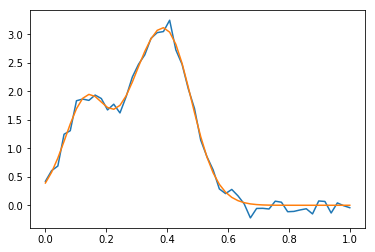

In [59]:
plt.plot(evaluation_points, y)
plt.plot(evaluation_points, out_coord_descent)